# Chapter 9: Time-Varying Volatility #
&copy; 2022 Kenneth Winston

[Benjamin Graham](http://c250.columbia.edu/c250_celebrates/your_columbians/benjamin_graham.html) famously anthropomorphized the US stock market, attributing wild emotional swings to "Mr. Market."[$^1$](#nine_footnotes) Sometimes Mr. Market was fearful, usually after a sufficiently traumatic negative event. At those times Mr. Market would sell valuable assets cheaply. Other times Mr. Market was greedy, and was willing to pay unrealistically high prices. The essence of "value investing" espoused by Graham &mdash; and later by his most successful student, [Warren Buffet](https://www.biography.com/business-figure/warren-buffett) &mdash; was to take advantage of Mr. Market's changing moods.

Mr. Market's moods affect both valuation and volatility. We noted when discussing mixtures of normals in Section 7.3 that authors such as [Ang & Timmerman 2008](https://dx.doi.org/10.2139/ssrn.1919497) found that markets
>often change their behavior abruptly
and... the new behavior of financial variables often persists for several periods after such a change.

In Section 7.3 we explored a model that does a good job of embodying the observation that markets "often change their behavior abruptly:" mixtures of normals. But mixtures of normals don't address the persistence that Ang & Timmerman and others have observed. In this chapter, we'll study volatility models that are aimed at <u>both</u> realistic behavior change and realistic persistence.

## 9.1 Historical Volatility ##

We know that even draws taken from a well understood distribution will have considerable sampling variation. So is it possible that abrupt changes and regime persistence in volatility are just due to ordinary sampling variation?

Let's examine the volatility of the US stock market starting in July 1926. To start, in the next cell we'll compute the annualized standard deviation of monthly log-returns from July 1926 to the end of last year. 

In [1]:
%matplotlib inline
import qrpm_funcs as qf
import numpy as np
#Find long-term standard deviation of US stock market
#Uses Ken French's website

#Cut off at last yearend
lastday=qf.LastYearEnd()
ld_yyyymm=int(lastday[:4]+lastday[5:7])
Date,market_minus_rf,SMB,HML,RF=qf.getFamaFrench3(enddate=ld_yyyymm)

ActualReality=qf.LogReturnConvert(market_minus_rf,RF)

#Compute overall monthly standard deviation
targetsd=np.std(ActualReality)

tstr='Annualized standard deviation of US stock market,\n'
tstr+=str(Date[0])[:6]+'-'+str(Date[len(Date)-1])[:6]
tstr+="(%.1f years)" % float(len(market_minus_rf)/12)
tstr+=': %.2f%%' % float(targetsd*np.sqrt(12))
print(tstr)

Annualized standard deviation of US stock market,
192607-202112(95.5 years): 18.42%


To show what sampling variation looks like, Figure 9.1 shows draws from a normal distribution with mean 0 and standard deviation equaling the historical standard deviation we just obtained.

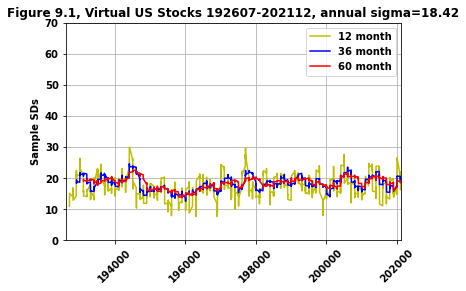

In [2]:
#Generate virtual reality with random normal draws with targetsd
import random

random.seed(3.14159265)
VirtualReality=[random.gauss(0,targetsd) for i in range(len(ActualReality))]

#Generate sample standard deviations for 3 lookback periodicities
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(VirtualReality,lookbacks)

#Draw the graph with 3 lines for the 3 periodicities
colors=['y-','b-','r-']
tstr='Figure 9.1, Virtual US Stocks '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
tstr+=', annual sigma=%.2f' % float(targetsd*np.sqrt(12))
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

We've labeled Figure 9.1 with dates. But these are not real dates &mdash; they are *merely corroborative detail intended to give artistic verisimilitude*[$^2$](#nine_footnotes) to the figure. Figure 9.1 is comprised of the same number of observations that we used above to find the long-term volatility of the US stock market, which is the target volatility in Figure 9.1. Otherwise, Figure 9.1 is virtual.

The yellow line shows sample standard deviations computed over rolling 12-month periods; blue shows annualized 36-month sample standard deviations; and red shows 60-month. The red line is the smoothest as it has the most opportunity to average out individual sampling quirks.

By comparison, Figure 9.2 shows reality: sample annualized standard deviations taken from real US stock market data over 12, 36, and 60-month trailing periods:

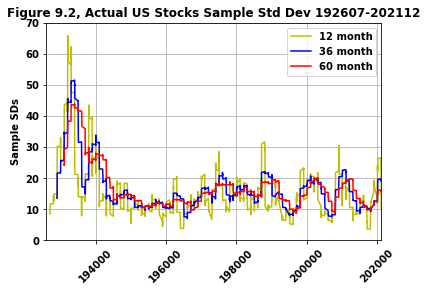

In [3]:
#Generate sample standard deviations
lookbacks=[12,36,60]
SampleSd=qf.GenSampleSd(ActualReality,lookbacks)

#Graph
colors=['y-','b-','r-']
tstr='Figure 9.2, Actual US Stocks Sample Std Dev '+str(Date[0])[:6]
tstr+='-'+str(Date[len(Date)-1])[:6]
qf.PlotSampleSd(tstr,Date,SampleSd,lookbacks,colors)

The differences between Figure 9.1 and Figure 9.2 are dramatic. The most obvious difference is the long high-volatility regime in Figure 9.2 consisting of the Great Depression of the 1920s and 1930s. This was far beyond the kind of sampling variation shown in Figure 9.1. Actual reality is more complicated than virtual reality. It would be nice to ignore that, but acting on the mistaken belief that we live in the world of Figure 9.1 will inevitably lead to a painful adjustment.

The standout features of Figure 9.2 are the spikes &mdash; especially evident in the yellow line &mdash; that occur because of large negative shocks: the Great Depression; the stock market crash of October, 1987; and in 2008-2009. None of these would have been observed if we had just sampled from a lognormal.

In addition to protruding periods of very high volatility in the real data, a close look reveals regimes of persistent low volatility. For example the two decades of the 1950s and the 1960s showed volatility mainly in the low teens, as did the period 2003-2006.

It certainly seems plausible that major economic events cause the financial markets to have volatility memory. In the Great Depression, it was not clear for quite a while whether or not the US would survive without major changes, if at all.

Fortunately there was not a complete break in the rule of law in the US. Complete breaks occur frequently, almost inevitably, in history as we pointed out in Section 7.1.4 with examples in Russia, China and Cuba. On the other hand it could be argued that the New Deal legislation passed in the US in the wake of the Great Depression reshaped the social and economic contract, so there was a partial break.

The calm period of the 1950s and 1960s corresponded to a number of soothing factors &mdash; the end of a World War, stable demographics, household formation, etc.

The reasoning applied to these large macroeconomic regimes can be extended to lesser events such as the [1986 Tax Reform Act](https://www.nber.org/papers/w2659.pdf) in the United States. Anticipation and eventual passage of this law created short-term market volatility: the yellow line in Figure 9.2 spiked to over 30% for three months at the end of 1986. But eventually markets adjusted to the new rules and volatility subsided.

## 9.2 Options and Volatility ##

We have noted that Harry Markowitz was apparently the first (in 1952) to suggest that volatility (standard deviation) was a good metric for how much information we lack about the future, i.e. Frank Knight's concept of risk.

We have also noted that we live in a world of Knightian Uncertainty, where we don't know the probability distribution of outcomes. If we did, we would know future volatilities. But we don't even know how much we don't know about the future.

This lack of knowledge about our lack of knowledge is good news for market participants called **`volatility traders`**: they would not have jobs if everyone knew future volatility. But in fact there are lively markets where participants are able to express views about future volatility.

Many of the strategies to bet on future volatility involve options, so the next section briefly reviews options terminology.

### 9.2.1 Review of Options Terminology ###

The owner of a **`European call option`** has the right (but not the obligation) to purchase an **`underlying`** entity (such as a share of a particular stock; a unit of an index such as the Standard & Poors 500; or an ounce of gold) at an agreed-on price (called the **`strike price`**) on a certain date in the future. This date is called **`maturity`** or **`expiration`** of the option; after that date, the option no longer confers any power on its owner. If the call option owner chooses to use its right to purchase, it is said to have **`exercised`** the option. An **`American call option`**[$^3$](#nine_footnotes) has the same properties, except it can be exercised on or before (not just on) a certain date in the future.

A **`call writer`** is the entity on the other side of the transaction from the call owner: the call writer agrees, at the call owner's discretion, to sell the underlying entity at the agreed-on price on (or before, if American) a certain date. The call writer has no discretion; it merely awaits a command from the call owner which the call owner may or may not choose to exercise. Because the call writer is submitting to the call owner's self-interest, the call owner must pay the call writer an inducement to cede power. The consideration paid by the call owner to the call writer is the **`call premium`**.

Many options are **`cash settled`**, meaning the purchase of the underlying does not actually occur. For example, if a call owner exercises the right to buy an underlying at a strike price of \\$100 at a time when its market price is \\$120, under cash settlement the call writer would simply pay \\$20 to the call owner. However if the option has **`physical settlement`**, upon exercise the call owner pays the strike price to the call writer, who simultaneously delivers a unit of the underlying to the call owner.

Whether through cash or physical settlement, a European call option is worth $max(X_T-K,0)$ at maturity time $T$, where $X_t$ is the market price of the underlying at time $t$ and $K$ is the option's strike price. $max(X_T-K,0)$ is called the **`payoff`** of the call option.

In practice in many cases, calls are not bilateral contracts. Instead, an exchange (such as the [Cboe, formerly the Chicago Board Options Exchange](http://www.cboe.com)) stands between all call owners and all call writers. Call owners pay the premium to the exchange and call writers receive the premium from the exchange, but the exchange collects collateral (called **`margin`**) from call writers to minimize the chance that they collectively fail to fulfill their obligations in the event of exercise. Upon exercise, physical or cash settlement also takes place through the exchange.

The owner of a **`put option`** has the right (but not the obligation) to sell an underlying entity to a **`put writer`** (or to an exchange standing between owners and writers) with conditions similar to a call option. A European put option has payoff equal to $max(K-X_T,0)$ at maturity time $T$.

Consider an investor who establishes a three-position portfolio $UPC$ consisting of:
- a unit of the underlying;
- a put on that underlying; and
- a written (short) call on that underlying.

The put and the call have the same maturity and the same strike price. If, at maturity, the underlying is worth less than the common strike price then the call will be worthless but the put will be worth the difference between the strike price and the underlying, so the portfolio $UPC$ will be worth the strike price. Similar logic shows that if the underlying is worth more than the strike price at maturity, then $UPC$ will also be worth the strike price. Thus by no-arbitrage, the portfolio $UPC$ is the same as a risk-free zero-coupon bond that will be worth the strike price at maturity time $T$.

This relationship for same-parameter European options on the same non-dividend-paying underlying is called **`put-call conversion`** or **`put-call parity`**:
$$X_t+P_t-C_t=exp(-r(T-t))K\label{eq:put_call_conversion}\tag{9.1}$$
Here, as above, $T$ is the maturity time; $X_t$ is the price of the underlying at time $0\leq t\leq T$; and $K$ is the common strike price of the options.$P_t$ and $C_t$ are the put and call premia, respectively, at time $t$, of options on the underlying struck at $K$ with maturity time $T$. The RHS of \eqref{eq:put_call_conversion} is the current price of a riskless zero-coupon bond that pays the common strike price $K$ at the common maturity $T$; $r$ is the riskless discount rate over the horizon $T$.

Options are a type of **`derivative security`**. Such securities derive their prices from other more fundamental observables, including stock prices, bond prices, commodity prices, and interest rates.

The prices (premia) of many options derive from the following five inputs. We've seen the first four already; the fifth input is new but not surprising:
- $X$, the current price of the underlying asset (such as the S&P 500);
- $K$, the strike price of the option;
- $T$, the time to maturity of the option;
- $r$, the risk-free rate of interest; and
- $f(x)$, the probability density function of the underlying asset's price at time $T$.

More complex options may have other inputs; for example, if the underlying pays dividends then the dividend rate or even a calendar of scheduled dividend payments may be input. In narrative form, a generic formula for the price of a simple option looks like this:
$$Price(\text{option})=f(\text{underlying price}, \text{strike price}, \text{time},$$
$$\quad\quad\quad\text{rf rate}, \text{underlying density function})\label{eq:generic_option_pricing}\tag{9.2}$$

In order to move from the generic formula \eqref{eq:generic_option_pricing} to a specific formula, assumptions about the behavior of the underlying asset need to be made. We noted at the beginning of Chapter 4 that the [Black-Scholes option formula](https://doi.org/10.1086/260062) is based on the assumption that underlying assets follow lognormal random walks as in (3.22)\eqref{eq:sde_percentage_changes}.

Using the lognormal assumption and an arbitrage argument, Black and Scholes showed that the price of a call option could be approximated by a continuously updated combination of the underlying and cash. That led them to a differential equation for the price of a call option. The mean of the underlying distribution did not appear in this differential equation and thus didn't appear in the Black-Scholes formula: the only distribution parameter needed is the underlying's standard deviation of log-returns.

Black and Scholes solved the differential equation to obtain their well-known formula for the price of a call option $C(X,K,T,r,\sigma)$:
$$C(X,K,T,r,\sigma)=X\cdot N(d_1)-K\cdot exp(-rT)N(d_2)$$
$$\text{where}\label{eq:black_scholes}\tag{9.3}$$
$$d_1=\frac{ln\bigl(\frac{X}{K}\bigr)+\bigl(r+\frac{\sigma^2}{2}\bigr)T}{\sigma\sqrt{T}}\quad\text{and}\quad d_2=d_1-\sigma\sqrt{T}$$

### 9.2.2 Market Volatilities and Volatility Markets ###

We already know from Chapter 7 that Black-Scholes' basic assumption of underlying lognormal random walks isn't true. We'll explore the implications of non-normality further below.

For now, note that the first four Black-Scholes inputs are easily observable. The fifth (volatility) can be observed in the past, but as we've pointed out above, volatility is not constant and we don't know what it will be over the future life of option.

While we can't observe future volatility, we might be able to observe current options prices. So when the options of interest are traded in a market like the [Chicago Board Options Exchange](www.cboe.com) or the [Eurex](https://www.eurexchange.com/exchange-en/products), we can rearrange \eqref{eq:black_scholes} so that observables are on the right-hand-side:
$$ImpVol(\text{option})=g(\text{underlying price}, \text{strike price}, \text{time},$$
$$\quad\quad\quad\text{rf rate}, \text{option price})\label{eq:generic_implied_volatility}\tag{9.4}$$

The standard deviation that was an input to \eqref{eq:black_scholes} is rebranded as **`implied volatility`** in \eqref{eq:generic_implied_volatility}: its value is implied under the assumption that \eqref{eq:black_scholes} holds. Often an iterative procedure rather than a closed-form formula is applied to \eqref{eq:black_scholes} to determine the $g$ function in \eqref{eq:generic_implied_volatility}.

Higher underlying standard deviation means that more probability mass is pushed away from the center of the underlying's distribution, out to the tails. More probability in the tails means a higher probability of high values for an option. Thus, Black-Scholes \eqref{eq:black_scholes} will have a positive derivative with respect to its fifth argument, i.e. $\frac{\partial C}{\partial \sigma}>0$.

This indicates that the expectation of an underlying's volatility over the life of an option is closely linked to the price of that option. More expected volatility means a higher option price when all other arguments are held constant, and a higher option price reflects more expected volatility through \eqref{eq:generic_implied_volatility}. Because of this tight connection, sometimes options prices are quoted in volatility units rather than in monetary units.

So options markets can be seen as markets where underlying volatility is traded. A simple strategy that can express a view of future volatility is to buy  or write a **`straddle`**, which is a put option and a call option struck at the money and expiring at the same time in the future. (**`The money`** means the current price of the underlying.)

If we pay $p$ for the put and $c$ for the call, then if the underlying moves more than $p+c$ in either direction away from its current price, we will profit. If we knew future volatility, we would be able to tell if $p+c$ was too low (buy the straddle) or too high (write the straddle). Figure 9.3 shows the payoff patterns of the put, the call, and the straddle at time of maturity, where the strike is 100 and both the put and the call are assumed to cost 5.

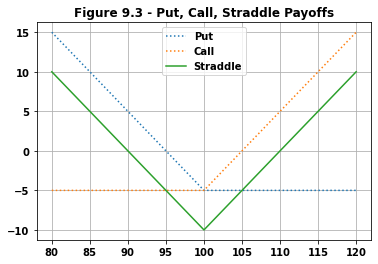

In [4]:
import matplotlib.pyplot as plt
#Draw graph showing payoff pattern of put,
#call and straddle

underprices=np.arange(80,121,1)

strike=100
cost=5
putprices=np.maximum(strike-underprices,0)-cost
callprices=np.maximum(underprices-strike,0)-cost
straddleprices=putprices+callprices
        
plt.plot(underprices,putprices,label='Put',linestyle=':')
plt.plot(underprices,callprices,label='Call',linestyle=':')
plt.plot(underprices,straddleprices,label='Straddle')
plt.title('Figure 9.3 - Put, Call, Straddle Payoffs') 
plt.legend()
plt.grid()
plt.show()

The most widely observed implied volatilities are those of the [Standard & Poors 500&reg;](https://www.spindices.com/indices/equity/sp-500), the US stock market index. The Chicago Board Options Exchange created the CBOE Volatility Index&reg;, more widely known as the [VIX&reg; Index](http://www.cboe.com/vix), to "measure the market's expectation of future volatility... based on options of the S&P 500&reg; Index." VIX&reg; actually uses a more sophisticated methodology that we'll [explore below](#vix_calculations), but for now it suffices to understand that VIX&reg; extracts levels of underlying S&P 500 volatility from options prices.

The VIX&reg; has been [published daily by the CBOE](http://www.cboe.com/micro/vix/historical.aspx) since the early 1990s, and data has been backfilled to the beginning of 1986. An older series called VXO is based on a different methodology, but basically tells the same story as VIX. Figure 9.4 shows the historical values of VXO and VIX retrieved from the FRED database:

Dates of 10 largest
['1987-10-19', '1987-10-20', '1987-10-26', '1987-10-22', '1987-10-23', '1987-10-27', '2020-03-16', '2020-03-12', '2020-03-18', '2008-11-20']
Yearend VIX 17.22


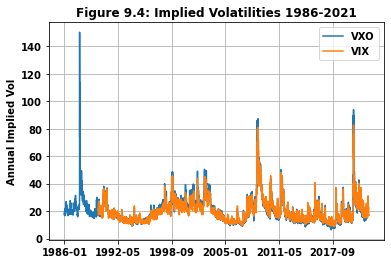

In [5]:
import pandas as pd
#Get VXO and VIX from Fred and
#graph them.

lastday=qf.LastYearEnd()
seriesnames=['VXOCLS','VIXCLS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Get rid of double nan's
vols=[ratematrix[i] for i in range(len(ratematrix)) if pd.notna(ratematrix[i]).any()]
vdates=[cdates[i] for i in range(len(ratematrix)) if pd.notna(ratematrix[i]).any()]

#vols now has VXO and VIX data where at least
#one of them is present.
x=range(len(vdates))
vxo=[row[0] for row in vols]
vix=[row[1] for row in vols]
plt.plot(x,vxo,label='VXO')
plt.plot(x,vix,label='VIX')
plt.title('Figure 9.4: Implied Volatilities '+vdates[0][:4]+'-'+vdates[len(vdates)-1][:4])

xskip=np.arange(0,len(vdates),1600)
tikskip=[vdates[x][:7] for x in xskip]
plt.xticks(xskip,tikskip)
plt.ylabel('Annual Implied Vol')
plt.legend()
plt.grid()
plt.show;

#10 largest dates
import heapq
print("Dates of 10 largest")
print([vdates[x] for x in heapq.nlargest(10, range(len(vxo)), key=vxo.__getitem__)])
#Yearend VIX
print("Yearend VIX",vix[-1])

The very large spike on the left of Figure 9.4 is the all-time high annualized implied volatility of 150, observed as a result of the stock market crash on and around October 19, 1987. The second-highest spike activity was on March 16, 2020 as the markets were shocked by the COVID-19 pandemic. And a spike of about 80 was observed on November 20, 2008 as markets considered the possible breakdown of the global financial system. For context, we've seen above that the annualized volatility of the US stock market since July 1926 is between 18 and 19 (percentage points).

Given the variation that is apparent in Figure 9.4, it is not surprising that markets for volatility are quite active. There are vehicles like [volatility and variance swaps](https://doi.org/10.3905/jod.1999.319129) and [VIX futures](http://cfe.cboe.com/cfe-products/vx-cboe-volatility-index-vix-futures) that allow positions to be taken on the future level of certain asset volatilities. This activity is called **`vega trading`** since "vega" is the term often used to denote an instrument's sensitivity to changes in underlying volatility.[$^4$](#nine_footnotes)

### 9.2.3 Volatility Skews ###
<a name="volatility_skew"></a>

Figure 9.4 showed a single time-varying option-implied volatility for the Standard & Poors 500. But at any given time, for the same underlying there are many traded options with varying strike prices and varying maturities. Each of these options has an implied volatility obtained from \eqref{eq:generic_implied_volatility}. Since the underlying asset can have only one actual volatility, we might hope that all options on the same underlying have the same implied volatility.

They don't. Figure 9.5 shows implied volatilities for options on the same underlying (S&P 500) with the same maturity, but with moneyness varying along the X axis. (Moneyness is the ratio of the strike price of the option to the current price of the underlying.)

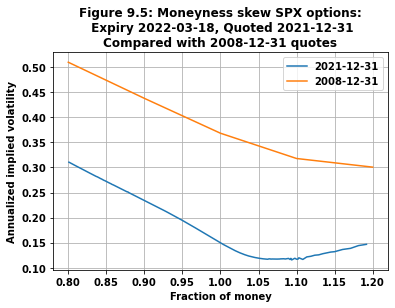

In [6]:
#Draw implied vols on two dates by moneyness
#Use downloaded file YYYY-12-31 from CBOE with all option prices on that day
#The full file takes a LONG time to read in.
#Separate code needs to be run once a year before this code segment; it
#is in Process_CBOE_file.ipynb and reads in file from CBOE datashop and
#outputs SPX_UnderlyingOptionsEODCalcs_YYYY1231.xlsx.

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Get all SPX options on CBOE as of December 31 of last year
yearend_string=str(datetime.datetime.now().year-1)+"-12-31"
df_opts=pd.read_excel(r"SPX_UnderlyingOptionsEODCalcs_"+yearend_string+".xlsx", \
                     engine="openpyxl")

#Subset the S&P 500 options with underlying SPX (eliminate SPXW, weekly expirations)
df_spx = df_opts[(df_opts.underlying_symbol == "^SPX") & (df_opts.root == "SPX")]

#Get S&P 500 price and quote date
spx_price = df_spx.active_underlying_price_1545.unique()[0]
quote_date = df_spx.quote_date.unique()[0]
stqd = str(quote_date)[:10]    #Display version YYYY-MM-DD

#Look between 80% of the money and 120% of the money
df_spx=df_spx[(df_spx.strike > .8*spx_price) & (df_spx.strike < 1.2*spx_price)]

#Eliminate expirations less than a week
df_spx=df_spx[df_spx.expiration>quote_date+np.timedelta64(6,'D')]

#Show strike skew of March options
df_60to90=df_spx[(df_spx.expiration>quote_date+np.timedelta64(60,'D')) & \
                 (df_spx.expiration<quote_date+np.timedelta64(90,'D'))]

strikes=[strike/spx_price for strike in df_60to90.strike.unique()]
implieds=[np.average(df_60to90[df_60to90.strike==strike].implied_volatility_1545) \
         for strike in df_60to90.strike.unique()]
sm1=[abs(str-1.) for str in strikes]
spx_ATM_60to90_implied = implieds[sm1.index(min(sm1))]

str_exp=df_60to90.expiration.iloc[0].strftime('%Y-%m-%d')
plt.plot(strikes,implieds,label=stqd)

#Add December 2008 graph
moneyness=[.8,.9,1.,1.1,1.2] 
imp2008=[0.510000164, 0.437931821, \
         0.368329438,0.31789782,0.30067243]
plt.plot(moneyness,imp2008,label='2008-12-31')

plt.xlabel("Fraction of money")
plt.ylabel("Annualized implied volatility")
plt.legend()
plt.grid()
str_title="Figure 9.5: Moneyness skew SPX options:\n Expiry "+str_exp+ \
    ", Quoted "+stqd
str_title+="\nCompared with 2008-12-31 quotes"
plt.title(str_title)
plt.show()

The blue line in Figure 9.5 shows implied volatilities of S&P 500 options as of the end of last year, with expiration about three months after that. The value of the blue line on this Figure 9.5 at "Fraction of money" equal to 1.00 is very close to the rightmost value of Figure 9.4.

As moneyness varies, the blue line decreases monotonically except for slight pertubations at the high end where options are more thinly traded and the data are less reliable.

The red line in Figure 9.5 is the set of implieds on December 31, 2008, in the thick of the Global Financial Crisis. It's similar in shape to the blue line, but it's translated up on the Y axis.

This kind of monotone pattern, typical of equity options, is called a **`volatility skew`**. In some cases &mdash; currency options, often &mdash; the moneyness curve dips in the middle but comes up at both ends; this is called a **`volatility smile`**.

In Figure 8.5 maturity was held constant while moneyness varied. If we hold moneyness constant (at 100%) while maturity varies, we get the patterns shown in Figure 9.6.

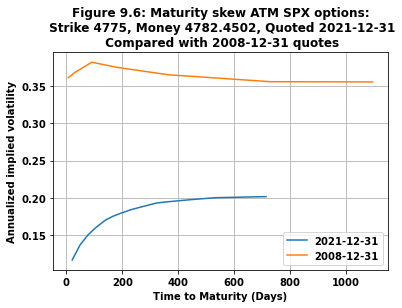

In [7]:
#Get time skew of ATM options
#Find closest to the money
min_to_money = min(abs(df_spx.strike.unique()-spx_price))
df_ATM=df_spx[abs(df_spx.strike-spx_price)<=min_to_money+5]

times=[int((time-quote_date)/np.timedelta64(1,"D")) for time in df_ATM.expiration.unique()]
implieds=[np.average(df_ATM[df_ATM.expiration==time].implied_volatility_1545) \
         for time in df_ATM.expiration.unique()]

#plt.plot(range(len(times)),implieds,label=stqd)
plt.plot(times,implieds,label=stqd)

#Add 2008-12-31 data
expiry=[7,31,91,182,365,730,1095] 
imp2008=[.3612,.3683,.3819,.3750, \
         .3651,.3558,.3555]
plt.plot(expiry,imp2008,label='2008-12-31')

plt.xlabel("Time to Maturity (Days)")
plt.ylabel("Annualized implied volatility")
plt.grid()
plt.legend()
str_strike=str(df_ATM.strike.iloc[0])
str_title="Figure 9.6: Maturity skew ATM SPX options:\n Strike "+str_strike
str_title+=", Money "+str(spx_price)+", Quoted "+stqd
str_title+="\n Compared with 2008-12-31 quotes"
plt.title(str_title)
plt.show();

The blue line in Figure 9.6 is a skew, although its range is not as wide as the moneyness skew in Figure 9.5.

The red line in Figure 9.6 is an upside-down smile, so of course it's called a **`volatility frown`**. In addition to the obvious highly elevated overall level, the red line shows the market's expectation that volatility would increase for about three months before subsiding slightly.

The downward slope &mdash; implied volatility decreases as moneyness increases &mdash; in Figure 9.5 is reliable, although the magnitude varies. Figure 9.7b below is 120%-80% moneyness skew in six-month options; it's always negative, usually more than $10\%$. That is, $120\%$ moneyness annualized implied volatilities have been less than $80\%$ moneyness implied volatilities of six-month options since at least 2004. There is some tendency for moneyness skew to increase during periods of market distress, like the terrorist attacks of September 11, 2001 or the Global Financial Crisis.

Figure 9.7a extends the anecdotal evidence of Figures 9.5 and 9.6: time skew is not as pronounced as moneyness skew. Figure 9.7a shows one year implied volatility minus one month implied volatility, both of at-the-money (100% moneyness) Standard & Poors 500 options. We used one year-one month because they are both heavily traded. This difference is usually (over $80\%$ of the time) positive &mdash; during normal markets, investors tend to demand a volatility time premium so that future implied volatility is higher than present implied volatility. But in market shocks, investors tend to buy short-term options rapidly and drive up near-term implied volatility. Thus time skew is a reasonably reliable market stress indicator.

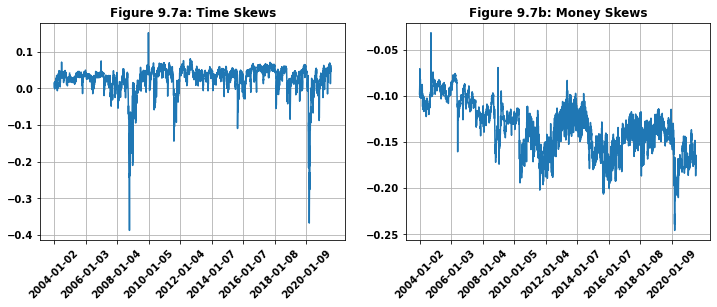

Percent time skew positive: 86.19%
Source: CBOE Datashop


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#Read time series of implied vol skews
#from csv file and graph them (time and
#moneyness skews)

df_skew=pd.read_csv('IV_skews.csv')
#skip daily info
stride=504
x=range(len(df_skew))

#Graph time and money skews side by side
plt.figure(figsize=(12,4))

#Time skew
#correct error
df_skew.loc[df_skew.index[df_skew.Time_skew>.4][0],"Time_skew"]=float("nan")

plt.subplot(1,2,1)
plt.plot(x,df_skew.Time_skew)
plt.xticks(range(0,len(df_skew),stride),df_skew.iloc[::stride].Date,rotation=45)
plt.grid()
plt.title('Figure 9.7a: Time Skews')

#Moneyness skew
#Moneyness skew was determined by taking all options with maturities
#between 90 and 360 days, and moneyness between (.7 and .9) on the low
#side, and (1.1 and 1.3) on the high side. Then implied volatilities were
#weighted by a metric that gives more weight to options closer to the targets
#(.8,180) and (1.2, 180), and averaged.
plt.subplot(1,2,2)
plt.plot(x,df_skew.Money_skew)
plt.xticks(range(0,len(df_skew),stride),df_skew.iloc[::stride].Date,rotation=45)
plt.grid()
plt.title('Figure 9.7b: Money Skews')
    
plt.show();

n_time_pos=len(df_skew[df_skew.Time_skew>0])
print("Percent time skew positive: {:.2f}%".format(100.*n_time_pos/len(df_skew)))
print("Source: CBOE Datashop")

## 9.3 Volatility Models ##

The nonconstant implied volatilities in Figures 9.5 and 9.6 are further evidence &mdash; not that any was needed &mdash; that the simple lognormal random walk model of underlying prices \eqref{eq:sde_percentage_changes} is wrong. There is no way to reconcile the different implied volatilities with the idea of a lognormal underlying distribution with a single, time-invariant volatility parameter.

The Black-Scholes formula (and other option pricing formulas like [Cox-Ross-Rubenstein]()) are essentially theorems that follow from certain axioms. If a theorem doesn't work empirically, then one of the axioms must be an incorrect description of reality. Mandlebrot used this line of reasoning as he examined the empirical failure of the Central Limit Theorem.

So we now turn our attention to what could be wrong with the assumptions behind the classical option pricing formulas, with the hope that we can get further insight, if not a perfect model. While the existence of active volatility markets mean that future volatility is unknown, that doesn't mean that we can't find patterns in volatility that can be used to generate descriptive models of the future.

These models are not prescriptive &mdash; they don't predict volatility. But they do generate patterns of volatility that are very much like the patterns we see in the markets. Thus the versions of the future that they generate are more likely to encompass the possible outcomes and their associated probabilities than are constant volatility models.

### 9.3.1 Risk-Neutral Density Recovery ###
<a name="risk_neutral_recovery"></a>

[Breeden and Litzenberger 1978](https://www.jstor.org/stable/2352653) decided to let the options market tell them what the underlying's distribution is, rather than try to tell the options market what it should be. Their approach is one of the ways to recover a risk-neutral cdf or pdf; from there the Ross Recovery Theorem can be applied as in Chapter 2.

A general way to write the price of a European call option is:
$$C(X,K,T,r,f_{X,T})=exp(-rT)\int_{K}^{\infty}(y-K)f_{X,T}(y)dy
\label{eq:generic_option_integral}\tag{9.6}$$
This is a more explicit version of \eqref{eq:generic_option_pricing}, using the notation of Section 9.2.1. But this is less explicit that Black-Scholes \eqref{eq:black_scholes} because the Black-Scholes assumption of underlying lognormality has not been made. Instead the underlying $X$'s probability density function at time $T$, $f_{X,T}$, has been included as an argument to the pricing function.

Breeden & Litzenberger's technique recovers $f_{X,T}$ from options price data. This technique does not disentangle risk preferences from probabilities, so the density function recovered using their method will be risk-neutral like $q(x)$ in Chapter 2, not real-world like $p(x)$.

Manipulating \eqref{eq:generic_option_integral} gives
$$exp(rT)C(X,K,T,r)=\bigl(\mu-\int_{-\infty}^K{}yf_{X,T}(y)dy\bigr)-K(1-F_{X,T}(K))\label{eq:breeden_litz_1}\tag{9.7}$$
Here $\mu$ is the average value of the underlying over the pdf $f_{X,T}$, and $F_{X,T}(x)$ is the cumulative distribution function arising from the density function $f_{X,T}$.

Taking the derivative of both sides of \eqref{eq:breeden_litz_1} with respect to the exercise price $K$ gives
$$exp(rT)\frac{\partial C(X,K,T,r)}{\partial K}=-Kf_{X,T}(K)-1+F_{X,T}(K)+Kf_{X,T}(K)$$
The $Kf_{X,T}(K)$ terms cancel, giving
$$F_{X,T}(K)=exp(rT)\frac{\partial C(X,K,T,r)}{\partial K}+1\label{eq:breeden_litz_2}\tag{9.8}$$
This gives an expression for the previously unknown cumulative density function in terms of the rate of change in the prices of options as strike prices change. We can approximate the derivative on the RHS of \eqref{eq:breeden_litz_2} by taking successive differences of observable options prices with incrementally higher strike prices, i.e. by using finite differences $\Delta C/\Delta K$. For example if we have a 3-month option struck at 90 and another 3-month option struck at 90.5, then two times the difference between their market prices will approximate the three-month forward cdf around 90.25.

Taking the derivative of \eqref{eq:breeden_litz_2} produces the pdf:
$$f_{X,T}(K)=exp(rT)\frac{\partial^2 C(X,K,T,r)}{\partial K^2}\label{eq:breeden_litz_3}\tag{9.9}$$
So if $C_1, C_2,$ and $C_3$ are the market prices of options struck at 90, 90.5, and 91, respectively, then
$$exp(rT)\frac{C_3-2C_2+C_1}{.5^2}$$
is an approximation to the risk-neutral pdf of the underlying around 90.5.

In practice, applying \eqref{eq:breeden_litz_3} (or its finite difference approximation) produces bumpy distributions. Some options may be thinly traded, producing asynchronous quotes that lead to noisy pdfs. Often some kind of smoothing method, like a cubic spline, is applied to fill and smooth the recovered pdf. Another approach is to fit a smooth function to the observed moneyness volatility curve like those in Figure 9.5. Then the smoothed volatilities can be used as inputs to \eqref{eq:black_scholes} to get prices that are input to \eqref{eq:breeden_litz_3}.

The risk-neutral distribution that results from this recovery and smoothing process can be used by traders to suggest arbitrage ideas in places where the trader feels the options market is being particularly unreasonable; too risk-averse; or not risk-averse enough.

### 9.3.2 Real-World Density Recovery ###

The recovered risk-neutral density function can be used together with the Ross Recovery Theorem (Section 2.9 above) to find real-world densities implied by observable options prices under Ross's assumptions.

We noted in Section 2.9 that observable options prices could be used to produce a square $n\times n$ matrix $Q$ whose $(i,j)$ entry is the probability of transitioning from state $i$ to state $j$ over a given time period. To form $Q$ we need to observe options prices at many different strikes and maturities.

For example, suppose we can observe prices of options expiring in one month with strikes of $90, 90.5, \dots, 110$. That would allow us to form $n=39$ second differences, corresponding to 39 states to which the Ross Recovery Theorem can be applied. State 1 is a price of $90.5$; state 2 is a price of $91$, $\dots$, state 39 is a price of $109.5$. 

Let's say the current state's index is $c=20$, i.e. a price of \\$100. Then the prices of one-month options that are currently trading will let us fill in the $c^{th}$ row of the desired $Q$ matrix, where $Q$'s given time period is one month. But what do we do to fill in other rows of $Q$? For example suppose $i$ indexes the state where the underlying's price is $105$ and $j$ indexes the state where the underlying's price is $98.5$. How do we find $q(i,j)$, the probability of transitioning from \\$105 to \\$98.5 over one month?

To fill in the rest of $Q$, we'd need to look at prices of options that expire in two months; in three months; $\dots$; in 39 months. In practice it would be unlikely that we'd have all the necessary observations, but we might be able to fill in all the requisite data by interpolating between observed prices.

Once we have all $n$ second differences of prices (39 in our example, derived from 41 strike prices) over all the maturities (each of the next 39 months in our example), we can form a $n\times n$ matrix $Q_c$ whose $(i,t)$ entry is $q(c,i,t)$: the probability of transitioning from the current state $c$ to state $i$ between now and time $t$, $t=1,\dots,39$.

The $c$ row of the desired matrix $Q$ is the first column of the matrix $Q_c$, i.e. the vectors marked in red below are the same:

$$
 Q=
  \left[ {\begin{array}{ccc}
   \vdots & \ddots & \vdots\\
   \color{red}{q(c,1)} & \color{red}{\cdots} & \color{red}{q(c,m)} \\
   \vdots & \ddots & \vdots\\
  \end{array} } \right]
$$

$$
 Q_c=
  \left[ {\begin{array}{ccc}
   \color{red}{q(c,1,\Delta t=1)} & \ddots & q(c,1,\Delta t=m)\\
   \color{red}{\vdots} & \cdots & \vdots \\
   \color{red}{q(c,m,\Delta t=1)} & \ddots & q(c,m,\Delta t=m)\\
  \end{array} } \right]
$$

From this observation we can bootstrap the rest of $Q$ by noting that going from now (time 0) to state $i$ at time $t$ means we went from now to state $j$ at time $t-1$, and then did a one-month transition from state $j$ to state $i$. Summing, we get
$$q(c,i,\Delta t=t)=\sum_{j=1}^n q(c,j,\Delta t=t-1)q(j,i)$$

In other words, the $(i,t)$ entry of the known matrix $Q_c$ is the dot product of:
- column $i$ of the as-yet-unknown $n\times n$ matrix $Q$; and
- column $t-1$ of $Q_c$.

We also know &mdash; since things have to transition from somewhere or to somewhere &mdash; that $Qu=Q^{\intercal}u=u$ where $u$ is the vector of all ones.

Putting the observations of the previous two paragraphs together in a matrix equation gives
$$\bigl(Q_c(2,n) | u\bigr)=Q^{\intercal}\times\bigl(Q_c(1,n-1) | u\bigr)$$
where $Q_c(a,b)$ consists of columns $a$ through $b$ of $Q_c$ and "$|u$" means a column of all ones is appended after the last column of the matrix.

Solving for $Q^{\intercal}$ gives
$$Q^{\intercal}=\bigl(Q_c(2,n) | u\bigr)\bigl(Q_c(1,n-1) | u\bigr)^{-1}\tag{9.12}$$
This retrieves the entire risk-neutral one-period state transition matrix from the Breeden-Liztenberger risk-neutral probabilities extracted from multiple time periods.

Getting this process to work in practice requires a lot of assumptions and a lot of data. We won't really have the $n(n+2)$ independent observations needed, and the way we fill in missing observations can affect the spectral analysis described in Section 2.9. But when used with caution, this process can deliver a partial description of a possible real-world density function of an underlying implied by market prices of its options.

### 9.3.3 Stochastic Volatility Modeling ###

The Black-Scholes model for option pricing started with the assumption that the underlying variable $x_t$ &mdash; for example the price of a stock at time $t$ &mdash; followed a lognormal stochastic process like the ones we introduced in Chapter 3:
$$\frac{dx}{x}=\alpha dt + \sigma d\beta\label{eq:repeat_sde}\tag{3.22}$$

Of course our point in this chapter is that it's unrealistic to assume that $\sigma$ is a constant. $\sigma$ varies in every way possible &mdash; over time; as $x_t$ varies; even when none of the variables in \eqref{eq:repeat_sde} vary, i.e. across option strike prices or expiration times.

So starting in the 1980s, a number of models were created that attempted to improve \eqref{eq:repeat_sde} by removing the requirement that volatility is constant:
$$\frac{dx_t}{x_t}=\alpha dt + \sigma(t,x_t) d\beta\label{eq:svm_sde}\tag{9.15}$$

But \eqref{eq:svm_sde} is just notation. The difficulty is in finding a realistic model for $\sigma(t,x_t)$. For one thing, realistic models will need to reflect the fact that volatilities are range-bound: they can't be negative and they can't increase forever. In fact volatilities of risky assets can't even stay near zero for very long periods because then the asset would be risk-free.

If volatilities could increase forever then swings would get more and more violent, and the stability necessary for market participants to have enough confidence to trade would be lost. [William Butler Yeats](https://www.poetryfoundation.org/poems/43290/the-second-coming) poetically expressed conditions of unbounded volatility:
>*Turning and turning in the widening gyre;<br>
The falcon cannot hear the falconer;<br>
Things fall apart; the centre cannot hold<br>
Mere anarchy is loosed upon the world*

Yeats was commenting on the chaos leading to World War I. As we've previously seen, the complete demises of markets in Russia, China, and Cuba were consequences of wider societal restructurings where "things fell apart." Wild market swings accompany wars and revolutions; they both reflect the widening gyre, and add to it. Anecdotally it appears that the centre cannot hold above a sustained $50\%$ annualized standard deviation of log-returns, although short-lived spikes above this level are often seen.

So modelers used <a href="#ornstein_uhlenbeck">Ornstein-Uhlenbeck</a> processes to capture the range-bound nature of variance (and volatility, its square root). The [Heston 1993 model](https://doi.org/10.1093%2Frfs%2F6.2.327), for example, is
$$dv(t)=\kappa[\theta-v(t)]dt+\varphi\sqrt{v(t)}dz(t)\label{eq:heston_model}\tag{9.16}$$
Here $v(t)=\sigma^2(t,x)$ is variance, but Heston's model does not make use of the $x$ argument. $dz$ is a Wiener process with correlation $\rho$ with the underlying's process $d\beta$. $\kappa$, $\theta$, and $\varphi$ ("volvol," the volatility of volatility) (e constant parameters. Heston notes that \eqref{eq:heston_model} is the same equation as Cox, Ingersoll, and Ross's short rate model (3.61).

Models like \eqref{eq:heston_model} are called **`Stochastic Volatility Models`**. If $2\kappa\theta>\varphi^2$ (the "Feller Condition"), then the variance will almost surely stay above zero[$^5$](#nine_footnotes).

[Heston 1993](https://doi.org/10.1093%2Frfs%2F6.2.327) derives a closed-form formula for stock, bond, and currency options based on \eqref{eq:svm_sde} and \eqref{eq:heston_model}. The formulas are messy and involve some numerical integration. A large literature accompanied and followed Heston's results with variants and generalizations.

We noted in Chapter 3 that the original Vasicek model for short interest rates contemplated constant parameters. This was later generalized by Hull and White (and others) to allow nonstochastic but time-varying parameters to better capture interest rate curves. Similarly, parameters in \eqref{eq:heston_model} can be made to vary in a way that models the various types of skew that we saw in Section 9.2 above.

### 9.3.4 Local Volatility Modeling ###

[Bruno Dupire](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.320.5063&rep=rep1&type=pdf) and others took a different approach to the varying nature of $\sigma(t,x_t)$. Dupire’s approach relied on the Breeden-Litzenberger process to extract from options price an implied time-varying probability density function $f(t,x)$ for the underlying asset $x$.

The **`local volatility model`** (“LVM”) gathers data for as many option expiration times $tex_1, tex_2,\dots, tex_n$ as possible, i.e. for which robust data at many strike prices is available. For each $tex_i$, LVM computes the density function $f(tex_i,x)$ using \eqref{eq:breeden_litz_e} and some kind of interpolation/smoothing algorithm to treat the market's inconsistency. Another interpolation/smoothing algorithm is applied between expiration times to produce a single smooth density function $f(t,x)$.

Dupire's insight was that the density function could be mapped into a volatility surface $\sigma(t,x)$. That is, it is possible to find a volatility function $\sigma(t,x)$ that:
- when used with \eqref{eq:svm_sde} and an option pricing method like Black-Scholes, produces the observed option prices in the market; and
- is consistent with the market-derived density function $f(t,x)$.

Dupire used the Fokker-Planck equation that ties together volatilities and density functions. Dupire shows that when applied to \eqref{eq:svm_sde}, it says
$$\frac{\partial f(t,x)}{\partial t}=\frac{\partial}{\partial x}\bigl(\alpha xf(t,x)\bigr)+\frac{\partial^2}{\partial x^2}\bigl(\frac{\sigma^2(t,x)}{2}f(t,x)\bigr)\label{eq:dupire_fokker}\tag{9.17}$$

We've dropped the subscript "t" on $x$ here, but it's the same $x$ as in \eqref{eq:svm_sde}. \eqref{eq:dupire_fokker} can be solved for $\sigma(t,x)$ so that the two conditions above are satisfied.

Black-Scholes and the related Black model for forward contracts have become familiar quoting conventions. Market participants essentially pretend that the innovations in \eqref{eq:svm_sde} are normal and put the non-normality in the variable $\sigma(t,x)$. The Local Volatility Model ties together time-varying volatility and the underlying distribution, so that the shapes (skews, smiles, smirks, frowns...) that are empirically evident can be mapped into a distribution. This allows options traders to think in terms of volatility surfaces (graphical representations of $\sigma(t,x)$) rather than in terms of pdfs.

### 9.3.5 SABR Modeling ###

Unfortunately there is a flaw in the LVM. It does not actually reflect reality as current prices change. We'll show how the problem and give a brief description of the widely used SABR model that solves the problem. A full investigation of SABR is beyond our scope.

Massimo Morini[$^6$](#nine_footnotes) notes the following. Let the current price (the "money") of the underlying be $x_0$. Extend our notation so that $\sigma(x_0;t,x)$ means the volatility surface estimated through the LVM process when the current ($t=0$) price is $x_0$, the time to expiration is $t$, and the strike price is $x$.

Then instantaneously shock the current price up a little bit, $x_0\to x_0+epsilon$. The volatility surface will change. It's reliably observed in practice that the surface shifts up, $\sigma(x_0+\epsilon,t,x)\approx\sigma(x_0;t,x-\epsilon)$. This is shown in Figure 9.8, where the red curve is the original blue curve shifted right by 0.5.

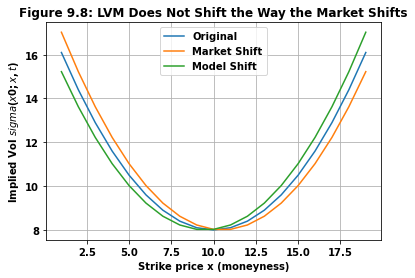

In [9]:
#Draw two smiles illustrating problem
#with LVM vs Market

strikes=np.arange(1,20)
original=[(s-10)**2/10+8 for s in strikes]
mktshift=[(s-.5-10)**2/10+8 for s in strikes]
modelshift=[(s+.5-10)**2/10+8 for s in strikes]

plt.plot(strikes,original,label='Original')
plt.plot(strikes,mktshift,label='Market Shift')
plt.plot(strikes,modelshift,label='Model Shift')

plt.ylabel('Implied Vol '+r'$sigma(x0;x,t)$')
plt.xlabel('Strike price x (moneyness)')
plt.grid()
plt.legend()
plt.title('Figure 9.8: LVM Does Not Shift the Way the Market Shifts')
plt.show()

It can be shown that the LVM does the exact opposite: it shifts the perturbed curve to the left (green curve). I have shown a perfect smile in the graph, but the right-shift seems to occur with imperfect smiles and with skews. I don't have a lot of intuition about why this occurs, but when a model contradicts a reliable market phenomenon, the model is wrong.

[Hagan et. al. 2002](https://web.archive.org/web/20150329204211/http://www.wilmott.com/pdfs/021118_smile.pdf) helpfully pointed out the shortcomings of the LVM model and put forward a new model that is still widely used. We'll just state the basic components of the **`SABR (Stochastic Alpha, Beta, Rho)`**, but won't pursue it further:

$$dx(t)=\sigma(t)x(t)^{\beta}dZ_x(t)$$
$$d\sigma(t)=\varphi\sigma(t)dZ_{\sigma}(t);\enspace\sigma(0)=\alpha\label{eq:sabr_model}\tag{9.19}$$
$$\mathbb{E}[dZ_xdZ_{\sigma}]=\rho dt$$
Like the Heston model \eqref{eq:heston_model}, SABR has a volvol φ and a correlation ρ between volatility and the underlying. However the dynamics are different and seem to fit market behaviors better.

### 9.3.6 VIX&reg; calculations ###
<a name="vix_calculations"></a>

The fact of [volatility skew](#volatility_skew) means that no single option's implied volatility gives the whole picture. That's because the underlying distribution isn't really lognormal. We saw that [Breeden-Litzenberger](#risk_neutral_recovery) allows the risk-neutral distribution to be recovered from options prices. Wouldn't it make more sense to compute the standard deviation of that distribution than to use the varying implied volatility from a single option?

Rhetorical question: of course it would make more sense, assuming there's a deep enough options market to get sufficient reliable data. Demerterfi, Derman, Kamal and Zou provided an elegant methodology to recover a risk-neutral standard deviation in a [Goldman Sachs white paper in March 1999](https://www.semanticscholar.org/paper/More-than-You-ever-Wanted-to-Know-about-Volatility-Demeterfi-Derman/3d9cfbe5ff32fd805f79c85b1e48fa9ac84e9128). Their approach was adopted by the [CBOE](https://www.cboe.com/) in its official calculations to produce the [VIX&reg; index](https://cdn.cboe.com/resources/vix/vixwhite.pdf).

Demerterfi et. al. note that It&ocirc;'s lemma applied to (3.22)\eqref{eq:sde_percentage_changes} results in the stochastic process identity
$$\frac{dX}{X}-d(ln(X))=\frac{\sigma^2}{2}dt\label{eq:return_minus_log}\tag{9.20}$$
This relationship does not depend on strong assumptions about the nature of the underlying's distribution: the $d\beta$ term that contains those assumptions has canceled out. All that is required is that $\sigma$, which is possibly time-varying, be reasonably well-behaved without large discontinuous jumps.

Integrating over time and taking the risk-neutral expectation of \eqref{eq:return_minus_log} gives
$$\sigma^2_{RN}=\frac{2}{T}\mathbb{E}\bigl[\int_0^T\frac{dX}{X}-ln\bigl(\frac{X_T}{X_0}\bigr)\bigr]=\frac{2}{T}\bigl[rT-\mathbb{E}\bigl[ln\bigl(\frac{X_T}{X_0}\bigr)\bigr]\bigr]\label{eq:variance_risk_neutral}\tag{9.21}$$
The latter equality is the result of the fact that in the risk-neutral measure, $\frac{dX}{X}=rdt+\dots$. Intuitively, the $\frac{dX}{X}$ term represents a continuously rebalanced portfolio of $\frac{1}{X}$ units of the underlying $X$, which is always worth $1$ and therefore has no risk; it must then match the risk-free return.

The log term in \eqref{eq:variance_risk_neutral} can be replicated by a portfolio of options, as follows. First, because in-the-money options are less liquid, we choose a strike price $K_0$ so that in the replicating portfolio put options are used for strikes below $K_0$ and call options for strikes above $K_0$. $K_0$ will actually be close to the forward value $exp(rT)X_0$ of the underlying. Using a cutoff like $K_0$ is intended to improve data quality but doesn't change the theoretical argument.

Demerterfi et. al. note the following identity that works for any $K_0$:
$$\frac{X_T-K_0}{K_0}-ln\bigl(\frac{X_T}{K_0}\bigr)\label{eq:log_replicating}\tag{9.22}$$
$$=\int_0^{K_0}\frac{1}{K^2}max(K-X_T,0)dK
+\int_{K_0}^{\infty}\frac{1}{K^2}max(X_T-K,0)dK$$
The two integrals on the RHS calculate the payoff at maturity time $T$ (with underlying price $X_T$ at that time) of a portfolio $\Pi$. $\Pi$ consists of (a) in the first integral, put options struck at every strike price $K$ from $0$ to some cutoff strike $K_0$, where the option struck at $K$ is given a weight $\frac{1}{K^2}$; and (b) in the second integral, call options struck at every strike price from $K_0$ to $\infty$, with the same weighting scheme. All the options are on the same underlying $X$. One integral or the other will have no value depending on whether or not $X_T$ is above or below $K_0$; it is not hard to verify that the nonzero integral will equal the quantity on the LHS.

The logarithm $ln\bigl(\frac{X_T}{X_0}\bigr)$ appearing in \eqref{eq:variance_risk_neutral} didn't have a $K_0$ term, and the logarithm $ln\bigl(\frac{X_T}{K_0}\bigr)$ appearing in \eqref{eq:log_replicating} didn't have an $X_0$ term. That's easily address by the decomposition
$$ln\bigl(\frac{X_T}{X_0}\bigr)=ln\bigl(\frac{X_T}{K_0}\bigr)+ln\bigl(\frac{K_0}{X_0}\bigr)$$
$ln\bigl(\frac{K_0}{X_0}\bigr)$ is known at time $t=0$ and thus can be safely extracted from the expectation operator. Thus \eqref{eq:variance_risk_neutral} becomes
$$\sigma^2_{RN}=\frac{2}{T}\bigl[rT-ln\bigl(\frac{K_0}{X_0}\bigr)-\mathbb{E}\bigl[ln\bigl(\frac{X_T}{K_0}\bigr)\bigr]\bigr]\label{eq:var_risk_neutral_K0}\tag{9.23}$$

The risk-neutral expectation at time $t=0$ of the value at time $T$ of the replicating portfolio $\Pi$ whose payoff is in \eqref{eq:log_replicating} is
$$\mathbb{E}\bigl[ln\bigl(\frac{X_T}{K_0}\bigr)\bigr]=
exp(rT)\frac{X_0}{K_0}-1+$$
$$exp(rT)\bigl(\int_0^{K_0}\frac{1}{K^2}P(K)dK
+\int_{K_0}^{\infty}\frac{1}{K^2}C(K)dK\bigr)\label{eq:log_replicating_K0}\tag{9.24}$$
Here $P(K)$ and $C(K)$ are prices of the replicating portfolio's put and call options on the underlying $X$ maturing at time $T$ and struck at $K$. Market-observed prices can be used here; of course there aren't continuously available options at every possible strike, but a finite approximation to \eqref{eq:log_replicating_K0} can be made.

Combining \eqref{eq:log_replicating_K0} with \eqref{eq:var_risk_neutral_K0} gives the estimate of variance from a replicating portfolio of options:
$$\sigma^2_{RN}=\frac{2}{T}\bigl[rT-ln\bigl(\frac{K_0}{X_0}\bigr)-exp(rT)\frac{X_0}{K_0}+1\label{eq:variance_replicating}\tag{9.25}$$
$$-exp(rT)\bigl(\int_0^{K_0}\frac{1}{K^2}P(K)dK
+\int_{K_0}^{\infty}\frac{1}{K^2}C(K)dK\bigr)\bigr]$$
If $K_0$ is set to equal the forward price $exp(rT)X_0$, the terms on the first line of \eqref{eq:variance_replicating} add to zero, leaving only the adjusted value of the portfolio of options.

The [actual formula](https://cdn.cboe.com/resources/vix/vixwhite.pdf) for VIX&reg; is the square root of a finite approximation to \eqref{eq:variance_replicating}:
$$\sigma^2=\frac{2exp(rT)}{T}\sum_i\frac{\Delta K_i}{K_i^2} O(K_i) - \frac{1}{T}\bigl(\frac{F}{K_0}-1)^2\label{eq:vix_actual}\tag{9.26}$$
where
- the index $i$ runs over the set of strike prices for which options with reasonable liquidity are available;
- $K_i$ is the strike price of the $i^{th}$ option used in the calculation where $K_i<K_j$ if $i<j$;
- $\Delta K_i$ is the half the distance between adjacent strike prices, $\Delta K_i=\frac{K_{i+1}-K_{i-1}}{2}$;
- $T$ is the time to expiration ($30$ days is targeted by taking an average of the calculation at the longest expiration less than $30$ days and the shortest expiration greater than $30$ days);
- $r$ is the risk-free (US Treasury bill) rate for maturity $T$;
- $O(K_i)$ is the observable bid-asked average price of the option used at strike $K_i$;
- $F$ is the forward price of the underlying, roughly $exp(rT)X_0$ (more below);
- $K_0$ is the dividing strike price where puts are used at strikes below $K_0$ and calls are used above $K_0$. Both a put and a call are used at $K_0$.

Put-call parity \eqref{put_call_conversion} shows that the price of a call equals the price of the put with the same parameters when their common strike price equals $exp(rT)X_0$, i.e. the forward price of the underlying. The VIX&reg; methodology looks for the strike price $K_{min}$ where the absolute difference between the put $P$ and the call $C$ struck at $K_{min}$ is the smallest. The $F$ in formula \eqref{eq:vix_actual} is defined as $F=K_{min}+exp(rT)(C-P)$. $F$ should be very close to the forward price $exp(rT)X_0$. The dividing line $K_0$ between puts and calls used in \eqref{eq:vix_actual} is the highest available strike price less than or equal to $K_{min}$. This makes the term $\frac{1}{T}\bigl(\frac{F}{K_0}-1)^2$ small, similar to the terms on the first line of \eqref{eq:variance_replicating}.

In the next code segment, a replicating portfolio of Black-Scholes puts and calls is used to calculate the value of \eqref{eq:vix_actual} at different values of $X_T$. The options all have $\sigma=.2$, so we expect the variance-replicating calculation to return $.04$. Figure 9.9 shows the results: 

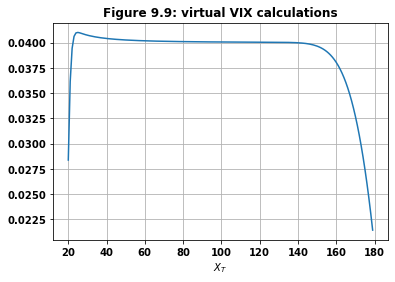

In [10]:
#compute pseudo-VIX at different underlying prices
import scipy.stats as spst

def black_scholes_call(under,strike,time,rfree,vol):
    #Formula 9.3 - returns price of call
    if under<=0 or strike<=0 or time<=0 or vol<0:
        return(0)
    d_1=(np.log(under/strike)+(rfree+vol**2/2)*time)/(vol*np.sqrt(time))
    d_2=d_1-vol*np.sqrt(time)
    call_val=under*spst.norm.cdf(d_1)-strike*np.exp(-rfree*time)*spst.norm.cdf(d_2)
    return(call_val)
#done with black_scholes_call

def black_scholes_put(under,strike,time,rfree,vol):
    #use put-call parity (9.1)
    return(black_scholes_call(under,strike,time,rfree,vol)- \
           under+np.exp(-rfree*time)*strike)
#done with black_scholes_put
    
r=0; T=.25; sigma=.2; delta_K=1
X_list=np.arange(20,180,1)
K_list=np.arange(20,180,delta_K)
z=[]
for X in X_list:
    K_0=np.exp(r*T)*X   #use forward price as divider between puts and calls
                        #so no adjustment needed
    yy=0
    for K in K_list:
        if K<=K_0: #Puts are used below the divider
            y=black_scholes_put(X,K,T,r,sigma)
        else: #Calls are used above the divider
            y=black_scholes_call(X,K,T,r,sigma)
        yy=yy+delta_K*y/K**2  #one over strike-squared weighting
    #y contains portfolio valued at X
    z.append(2*np.exp(r*T)*yy/T)

plt.plot(X_list,z)
plt.title("Figure 9.9: virtual VIX calculations")
plt.xlabel("$X_T$")
plt.grid()
plt.show()

Figure 9.9 shows that the calculation works well in a wide neighborhood around the center ($100$) of available options. Actual S&P 500 strikes are about $20$bps apart as a fraction of S&P price, which is even closer than the $1\%$ strike spacing used here.

## 9.4 Time Series Terminology ##

We will finish our study of time-varying volatility with the work of Robert Engle, Tim Bollerslev, and others who used time series techniques. For that, we'll need the terminology that we'll use for basic time series analysis. This section sets out our terminology and is not intended as course in time series, but rather as a reference for readers with knowledge of time series.

A **'time series'** is a set of data $X_t$ indexed by time. Typically values of $X_t$ where $t$ is in the past are simply data, while future values of $X_t$ are assumed to follow a stochastic process. For our purposes the stochastic process will be discrete and will contain data at a certain **`periodicity`**. The period can be a microsecond, a minute, a decade, or any other fixed amount of time.

We can define conditional distributions based on previous observations of the time series. When $t_1>t_2$, the notation $F[X_{t_1} | \{X_s, s\leq t_2\}]$ indicates the cdf for a future value $X_{t_1}$ of the time series given the information in previous values $\{X_s, s\leq t_2\}$. If we have a closed form for the conditional distribution $F[X_{t_1} | \{X_s, s\leq t_2\}]$, then the time series is **`autopredictive`**.

The conditional distribution framework reasonably contemplates us updating our beliefs. As the clock ticks (as $t$ increases), we build up more and more history. We get closer to the present, and eventually as the future becomes the present, variables become fixed and not stochastic. Suppose for example that $t_1=$the year 2050 and we form our belief as to the distribution of stock prices in 2050 based only on information about the stock market up to the year $t_2=2010$. That distribution will be different than the one we form if we have information about the stock market up to $t_2=2049$.

A time series is **`strongly stationary`** if $F(X_i,\dots,X_m)=F(X_{i+j},\dots,X_{m+j})$ for all $i\leq n$ and $j\geq 0$. It is **`nonstationary`** if not. A weaker form of stationarity is **`covariance stationarity`**, meaning $\mathbb{E}[X_t]$ is a constant independent of $t$, and $Cov(X_t,X_s)$ is only a function of $t-s$. Thus Variance$(X_t)$ is only a function of $t-t=0$, i.e. like the mean, variance is a constant independent of $t$ for a covariance stationary time series. A strongly stationary time series is covariance stationary if it has finite variance; it is however possible to find infinite variance strongly stationary time series that are not covariance stationary.

Many time series are not stationary, but often techniques are used to transform them into stationary series, which are easier to deal with.

The (possibly time-varying) mean $\mu(t)$ of a time series is straightforward: $\mu(t)=\mathbb{E}[X_t]$. The **`autocovariance function`** of a time series is $\sigma(s,t)=\mathbb{E}[(X_s-\mu(s))(X_t-\mu(t))]$. The **`autocorrelation function`** is $\rho(s,t)=\frac{\sigma(s,t)}{\sqrt{\sigma(s,s)\sigma(t,t)}}$.

If the time series is covariance stationary, then we can define the autocovaraiance function as $v(s-t)\equiv \sigma(s,t)$, i.e. all that matters is the difference in times. Similarly the autocorrelation function can be written $r(s-t)\equiv \rho(s,t)=v(s-t)/v(0)$ for a covariance stationary time series.

A time series is **`autoregressive of order p`** (written $AR(p)$) if the following holds for all $t$:
$$X_t=c+\sum_{i=1}^p{a_i X_{t-i}}+\epsilon_t\label{eq:arp_process}\tag{9.30}$$
Here $c,a_1,\dots,a_p$ are constants and the $\epsilon_t$ are iid with mean $0$ and variance $\sigma^2$. Often we start with initial conditions, where $X_0,\dots,X_{p-1}$ are known with certainty. We then begin introducing randomness through **`shocks`** (or **`innovations`**) embodied in the $\epsilon_t$.

Consider for simplicity an AR(1) process:
$$X_t=c+aX_{t-1}+\epsilon_t\label{eq:ar1_process}\tag{9.31}$$
The first step from the initial condition brings us to
$$X_1=c+aX_0+\epsilon_1$$
Iterating the AR(1) relationship up to time $t$, we obtain
$$X_t=\bigl(c\sum_{i=0}^{t-1}{a^i}+a^tX_0\bigr)+\sum_{i=1}^t{a^{t-i}\epsilon_i}=\bigl(c\frac{1-a^t}{1-a}+a^tX_0\bigr)+\sum_{i=1}^t{a^{t-i}\epsilon_i}\label{eq:ar1_iterated}\tag{9.33}$$

Note that if $|a|<1$, the term in large parentheses in \eqref{eq:ar1_iterated} converges to $c/(1-a)$ as $t\to\infty$, and if $|a|\geq 1$ the term is either unbounded or does not converge. For the AR(1) process to be stationary we must have $|a|<1$.

More generally for an AR(p) process, we can define the **`characteristic equation`**
$$z^p-a_1 z^{p-1}-\dots-a_p=0\label{eq:arp_characteristic}\tag{9.34}$$
The AR(p) process will be stationary iff the roots of this characteristic equation are all less than one in absolute value; i.e. they lie inside the unit circle on the complex plane. If any roots are outside the unit circle the process is ill-behaved: it rapidly heads off to infinite values. If there are roots on the unit circle and none outside the unit circle, then the process is a nonstationary **`unit root`** process that meanders.

Recall from Chapter 3 that a Markov Process is one where the current distribution's dependence on the past is limited to its dependence on the immediate previous distribution, not the entire history of how it got there.
$$Pr[X_n=v_n | X_{n-1}=v_{n-1},\dots,X_{0}=v_{0}]=Pr[X_n=v_n | X_{n-1}=v_{n-1}]\tag{3.26}$$
Thus an AR(1) process is essentially a Markov process, since (using \eqref{eq:ar1_process}):
$$Pr[X_n=v_n | X_{n-1}=v_{n-1},\dots,X_{0}=v_{0}]=Pr[\epsilon_n=v_n-c-av_{n-1}]=Pr[X_n=v_n | X_{n-1}=v_{n-1}]$$

A generalized definition of a Markov process is one where the current distribution depends only on a fixed finite number $p$ of previous observations, not the entire history. Thus an AR(p) process fits this more general definition of a Markov process.

Assume for simplicity that the parameter $c$ in an AR(p) process \eqref{eq:arp_process} is zero and therefore all means are zero. Multiply the defining equation by $X_{t-k} (k>0)$ and take expectations to get:
$$\mathbb{E}[X_t X_{t-k}]=\sum_{i=1}^p{a_i\mathbb{E}[X_{t-i}X_{t-k}]}\tag{9.35}$$
If the process is stationary, only the difference in times matters in defining autocovariances, so we have
$$v(k)=\sum_{i=1}^p{a_i v(k-i)}\quad and \quad v(0)=\sum_{i=1}^p{a_iv(-i)}+\sigma^2=\sum_{i=1}^p{a_iv(i)}+\sigma^2\tag{9.36}$$

Dividing both sides of the left-hand equation by $v(0)$ converts the v's (autocovariances) to r's (autocorrelations) and gives rise to a series of linear equations called the **`Yule-Walker equations`** (noting r(-i)=r(i)):

$$
  \left[ {\begin{array}{c}
   r(1)\\
   r(2) \\
   \vdots \\
   r(p) \\
  \end{array} } \right]
=
  \left[ {\begin{array}{ccc}
   1 & r(1) & \dots & r(p-1)\\
   r(1) & 1 & \dots & r(p-2) \\
   \vdots & \dots & \dots & \dots\\
   r(p-1) & r(p-2) & \dots & 1 \\
  \end{array} } \right]
  \left[ {\begin{array}{c}
   a_1\\
   a_2 \\
   \vdots \\
   a_p \\
  \end{array} } \right]
\label{eq:yule_walker}\tag{9.37}$$

A **`moving average process MA(q)`** is one where
$$X_t=c+\epsilon_t-b_1\epsilon_{t-1}-\dots-b_q\epsilon_{t-q}\label{eq:maq_process}\tag{9.38}$$
The $\epsilon$'s are iid with mean 0 and variance $\sigma^2$. We showed above in \eqref{eq:ar1_iterated} that a stationary AR(1) process can be transformed into something that looks like an infinitely expanding MA process going back to the first shock $\epsilon_1$. An actual MA process \eqref{eq:maq_process} only goes back a fixed number $q$ of terms.
Similarly, iterating an MA(1) process back to inception gives
$$X_t=c\bigl(\frac{1-b_1^{t+1}}{1-b_1}\bigr)+\epsilon_t-\sum_{i=1}^tb_1^iX_{t-i}\label{eq:ma1_iterated}\tag{9.39}$$
This looks something like an AR process, but it is infinitely expanding.

Similar to \eqref{eq:arp_characteristic}, define the characteristic polynomial for an MA(q) process
$$z^q-b_1 z^{q-1}-\dots-b_q=0\label{eq:maq_characteristic}\tag{9.40}$$

Then if the roots of \eqref{eq:maq_characteristic} are inside the unit circle (absolute value less than one), we can invert the MA(q) process into a stationary AR process. That is, for each $X_t$ in the MA(q) process, there will be a way to write $X_t$ as a stationary AR(t) process similar to \eqref{eq:ma1_iterated}.

Combining AR and MA processes, we can define an **`ARMA(p,q) process`** as one where
$$X_t=c+a_1 X_{t-1}+\dots+a_p X_{t-p}+\epsilon_t-b_1 \epsilon_{t-1}-\dots-b_q\epsilon_{t-q}\label{eq:arma_process}\tag{9.41}$$

It is convenient to introduce the **`backward and forward operators`** $B$ and $F$. For any time series $Y_t$, $BY_t=Y_{t-1}$, and $FY_t=Y_{t+1}$. $B$ is sometimes called the **`lag operator`**.

These operators make it easier to define and manipulate time series equations. We can rewrite an ARMA(p,q) process as
$$X_t=c+\bigl(\sum_{i=1}^p{a_i B^i}\bigr)X_t+\bigl(1-\sum_{i=1}^q{b_i B^i}\bigr)\epsilon_t\tag{9.42}$$

Assuming no unit roots of the AR characteristic equation, we can move the $X_t$ terms to the LHS and solve for $X_t$:
$$X_t=\frac{c}{1-\bigl(\sum_{i=1}^p{a_i}\bigr)}+\frac{1-\sum_{i=1}^q b_i B^i}{1-\sum_{i=1}^p{a_iB^i}}\epsilon_t\tag{9.43}$$

We can also solve for the innovations $\epsilon_t$:
$$\epsilon_t=\frac{-c}{1-\bigl(\sum_{i=1}^q{b_i}\bigr)}+\frac{1-\sum_{i=1}^p a_i B^i}{1-\sum_{i=1}^q{b_iB^i}}X_t\tag{9.44}$$

## 9.5 ARCH and GARCH Modeling ##

The **`ARCH (Auto-regressive Conditional Heteroskedasticity)`** model was introduced by [Robert Engle in 1982](https://doi.org/10.2307%2F1912773). Engle started a decades-long series of investigations into related time-series-based models, and won the [2003 Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/2003/engle/facts/) for his work.

The 1982 ARCH model started with the standard It&ocirc; process for log-prices like (3.21):
$$dx=\alpha(t,x)dt+\sigma(t,x)d\beta\tag{3.21}$$
The $\alpha(t,x)$ term is not important for volatility purposes, so Engle assumed $\alpha(t,x)=0$. He also assumed that $\sigma(t,x)=\sigma_t$, i.e. volatility is time-varying but not a function of the (log) price level x. Let $y=dx$ be the time series of changes in $x$. Then the ARCH model is
$$y_t=\sigma_t d\beta(t)\label{eq:arch_model}\tag{9.50}$$
As before, each $d\beta(t)$ is an independent draw from a standard normal (or more generally mean 0, variance 1) distribution. However now $\sigma_t$ &mdash; actually its square, the variance &mdash; is similar to an AR(p) process as in \eqref{eq:arp_process}:
$$\sigma_t^2=c+\sum_{i=1}^p{a_i y_{t-i}^2}=c+\bigl(\sum_{i=1}^p{a_i B^i}\bigr)y_t^2\label{eq:arch_sigma}\tag{9.51}$$

\eqref{eq:arch_model} and \eqref{eq:arch_sigma} together (along with the condition that $y$ is a strongly stationary time series) constitute the ARCH(p) model.

The relationship \eqref{eq:arch_sigma} is not exactly autoregressive in $\sigma_t^2$, as $\sigma_t^2$ does not directly depend on earlier values of the $\sigma^2$ series. Nor is it exactly a moving average, as the $y$'s are not iid like the $\epsilon$'s of \eqref{eq:maq_process}. But it has aspects of both kinds of standard time series. Also, the time is offset so that $\sigma(t)$ is not influenced by the latest shock $d\beta(t)$; otherwise \eqref{eq:arch_model} and \eqref{eq:arch_sigma} would be circular.

**`Heteroskedasticity`** (as opposed to the more tractable **`homoskedasticity`** that the usual condition of iid shocks imposes) refers to differing variances in the random draws taken to produce the shocks $y(t)$ in \eqref{eq:arch_model}. The heteroskedasticity is conditional because it depends on previous observations of the shocks.

The ARCH model captures some aspects of the kinds of volatility regimes that we saw in the US stock market graphs. The simple relationship \eqref{eq:arch_model} indicates that when volatility is high, the shocks to our series (S&P 500 log-prices, for example) will be higher. That in turn feeds into \eqref{eq:arch_sigma}, which averages recent shocks to get today's volatility, which will tend to be higher, which feeds on itself$\dots$

The $c$ term in \eqref{eq:arch_sigma}, which can be thought of as an anchor to the long-term average volatility, will dampen runaway tendencies. If the current volatility is high, then having $c$ in the expression will pull it down; if the current volatility is low, then having $c$ in the expression will pull it up. This is the same general idea as the long-term variance $\theta$ in the Heston model \eqref{eq:heston_model}.

In practice $p$ is usually small; in fact often $p=1$. If we square \eqref{eq:arch_model} (using \eqref{eq:arch_sigma} with $p=1$), the equation simplifies to:
$$y_t^2=(c+a_1 y_{t-1}^2)d\beta(t)^2\label{eq:arch1_squared}\tag{9.52}$$

Taking expectations of both sides of \eqref{eq:arch1_squared} shows that in order to avoid volatility becoming unbounded over time, $|a_1|<1$ and the long-term expected variance (as $t\to\infty$) $\mathbb{E}[\sigma_t^2]\to c/(1-a_1)$.

Squaring both sides of \eqref{eq:arch1_squared} and taking expectations gives:
$$\frac{\mathbb{E}[y_t^4]}{\mathbb{E}[d\beta(t)^4]}=c^2+2ca_1\mathbb{E}[y_{t-1}^2]+a_1^2\mathbb{E}[y_{t-1}^4]\label{eq:arch1_fourth}\tag{9.53}$$

The denominator of the left-hand side of \eqref{eq:arch1_fourth} is the kurtosis $\kappa_{\beta}$ of the innovation process; if the innovations are normal then $\kappa_{\beta}=3$. If the series is covariance stationary, then further manipulation (including the observation above that the limit as $t\to\infty$ of $\mathbb{E}[y_t^2]$ is $c/(1-a_1)$) allows us to find the long-term equilibrium kurtosis $\kappa_y$:
$$\kappa_y=\frac{(1-a_1^2)\kappa_{\beta}}{1-a_1^2 \kappa_{\beta}}\label{eq:arch1_long_kappa}\tag{9.54}$$
Under reasonable conditions ($\kappa_{\beta}>1$, the denominator of \eqref{eq:arch1_long_kappa} is positive), we will have $\kappa_{y}>\kappa_{\beta}$. In other words, the ARCH(1) process fattens the tails and creates more unusual events than would be found in a similar homoskedastic process.

[Tim Bollerslev](https://doi.org/10.1016/0304-4076(86)90063-1) extended the ARCH model in 1986 into the **`GARCH(p,q) (Generalized AutoRegressive Conditional Heteroskedasticity)`** model that is now widely used:
$$\sigma_t^2=c+\sum_{i=1}^p{\bigl(b_i \sigma_{t-i}^2\bigr)}+\sum_{j=1}^q{\bigl(a_j y_{t-j}^2\bigr)}=\\
c+\sum_{i=1}^p{\bigl(b_i B^i\bigr)}\sigma_{t}^2+\sum_{j=1}^q{\bigl(a_j B^j\bigr)}y_{t}^2\label{eq:garchpq_sigma}\tag{9.55}$$
The GARCH model of course includes \eqref{eq:arch_model}, only with the more complex variance updates shown in \eqref{eq:garchpq_sigma} replacing \eqref{eq:arch_sigma}.

The new term is directly autoregressive in $\sigma^2$ and is similar the ARMA(p,q) model in \eqref{eq:arma_process}. The autoregressive terms give persistence to volatilities, so if past volatilities were high (low) then future volatilities will tend to be high (or low). Shocks ($y$'s) get bigger too as volatilities increase, but if there happens to be some smaller shocks then the process will go the other way and there will tend to be a prolonged period of lower variance. The constant $c$ serves as an anchor, pulling the variance to some long-term average over time.

To make the process reasonable and stationary, we must have:
$$c>0;\quad a_i\geq0;\quad b_j\geq0;\quad\sum_{i=1}^p b_i + \sum_{j=1}^q a_j<1\label{eq:garch_conditions}\tag{9.56}$$

As with ARCH, the most commonly used form of GARCH(p,q) is the simplest: GARCH(1,1). The variance equation becomes:
$$\sigma_t^2=c+b_1 \sigma_{t-1}^2+a_1y_{t-1}^2\label{eq:garch11_sigma}\tag{9.57}$$
It can be shown that a GARCH(1,1) process has bounded volatility if and only if $a_1+b_1<1$. Further the long-term expected variance (as $t\to\infty$) is $\mathbb{E}[\sigma_t^2]=c/(1-a_1-b_1)$. As with ARCH(1), it can be shown that a nontrivial GARCH(1,1) process increases the kurtosis of the innovation process.

We can estimate parameters of a GARCH model by maximum likelihood. Here we assume the innovations $d\beta$ are normal. In that case, the usual log-likelihood function on normal density can be used:
$$LML(c,a_1,b_1|y_1,\dots,y_t)=-\sum_{i=1}^t{ln(\sigma_i)}-\sum_{i=1}^t{\frac{y_i^2}{2\sigma_i^2}}\label{eq:garch11_maxlike}\tag{9.58}$$
As with all log-maximum-likelihood functions, this is obtained by looking at the product $f_1(y_1)f_2(y_2)\cdot\dots\cdot f_t(y_t)$ where $f_i(x)$ is the appropriate pdf and $y_i$ are the observed data. In this case, the pdfs are normal with mean $0$ and standard deviations $\sigma_i$. Maximizing this product is the same as maximizing the logarithm of the product, which is the sum of the logs of the pdfs. That's what is shown in \eqref{eq:garch11_maxlike}.

This is used in conjunction with the recursion for variance, \eqref{eq:garch11_sigma}. The variance series must be seeded with an initial value, which is often just taken to be the sample variance of the observations $y_1,\dots,y_t$. That's a kind of cheating, since at time 0 we couldn't know what the future $y_i$'s were going to be. A purer initial guess would use only information known at time 0. However the initial guess usually doesn't make that big a difference in a sufficiently long time series.

Let's try this with the monthly US stock market data we showed above. We will use the cheat described in the previous paragraph and seed the process with the long-term volatility from mid-1926 to the end of last year. We found that initial value in the first code segment of this chapter. The resulting LML fit to the data is shown in Figure 9.10:

a=0.135
b=0.847
c=0.692


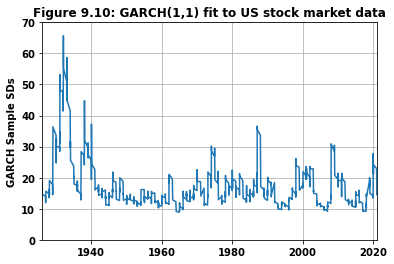

Annual sample std dev 18.4174528766247 = monthly variance of 28.266880871890958 bps
Stationary check (a+b less than one):  0.9819816664200475
Monthly target variance 38.422024062429585 bps
Target annualized standard deviation:  21.47240761417208


In [11]:
#fit GARCH(1,1) model
initparams=[.12,.85,.6]
a,b,c=qf.Garch11Fit(initparams,ActualReality)

#Display results
print("a=%.3f" % a)
print("b=%.3f" % b)
print("c=%.3f" % c)

#Draw graph
t=len(ActualReality)
minimal=10**(-20)
stdgarch=np.zeros(t)
stdgarch[0]=np.std(ActualReality)
overallmean=np.mean(ActualReality)
degarched=np.zeros(t)   #series to hold de-garched series y[t]/sigma[t]
degarched[0]=(ActualReality[0]-overallmean)/stdgarch[0]
#Compute GARCH(1,1) stddev's from data given parameters
for i in range(1,t):
    #Note offset - i-1 observation of data
    #is used for i estimate of std deviation
    previous=stdgarch[i-1]**2
    var=c+b*previous+\
        a*(ActualReality[i-1]-overallmean)**2
    stdgarch[i]=np.sqrt(var)
    degarched[i]=(ActualReality[i]-overallmean)/stdgarch[i]

#Annualize
stdgarch*=np.sqrt(12)

#Just show years
Year=[d/100 for d in Date]
    
plt.plot(Year,stdgarch)
plt.grid()
plt.title('Figure 9.10: GARCH(1,1) fit to US stock market data')
plt.ylabel('GARCH Sample SDs')
plt.axis([min(Year),max(Year),0,70])
plt.show();

print("Annual sample std dev",targetsd*np.sqrt(12),"= monthly variance of", \
      targetsd**2,"bps")
print("Stationary check (a+b less than one): ",a+b)
print("Monthly target variance",c/(1-a-b),"bps")
print("Target annualized standard deviation: ",np.sqrt(12*c/(1-a-b)))

The parameters show that the LML solution was stationary. The long-term annualized standard deviation projected at the end of last year was a little higher than the sample standard deviation over the entire period back to mid-1926, but is of the same order of magnitude.


In [12]:
#Compute before and after excess kurtosis
from scipy import stats
kurt_orig=stats.kurtosis(ActualReality,fisher=True)
kurt_degarch=stats.kurtosis(degarched,fisher=True)
print("Excess kurtois before and after deGarching:", \
      kurt_orig,kurt_degarch)

Excess kurtois before and after deGarching: 6.728574706975481 2.314680942506488


The "de-GARCHed" series is $y_i/\sigma_i$. Its excess kurtosis drops to about one third of the original. It's not quite zero which would make the distribution pretty close to normal. But it's much closer.

### 9.5.1 ARCH and GARCH variants ###

Over the years, an enormous set of variations on GARCH have been proposed and used. We will mention a few of them.

A recurring empirical regularity is an asymmetric response to returns: positive returns tend to be followed by less of an increase in volatility than do negative returns. But all the $y$ terms in \eqref{eq:garchpq_sigma} are squared, so the GARCH(p,q) model does not differentiate between volatility responses to positive and negative returns.

For theoretical background on why this asymmetry might exist, we turn to the **`Merton Model`**, named after Robert Merton. Merton received the [Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel](https://www.nobelprize.org/prizes/economic-sciences/1997/merton/biographical/) in 1997. We will talk more about this model in Chapter 11, but for now we'll see why it might suggest asymmetry.

At its simplest, the [Merton Model](https://doi.org/10.1111/j.1540-6261.1974.tb03058.x) assumes that companies (also called "enterprises") have two kinds of obligations: they have borrowed a certain amount of money, called $D$ (for "debt") which they need to pay back; and they have stockholders who own whatever is left over after the enterprise pays off its debt. Thus if the enterprise's entire value is $V$, we have $S=V-D$ where $S$ is the stock (also called "equity") portion of the enterprise.

But if $D>V$ that's not true: there's nothing left over for the stockholders. So more precisely, $S=max(0,V-D)$. If $D>V$, then the debtholders don't get fully repaid; they just get $V/D$ dollars back per dollar than they loaned. On the other hand $D$ is fixed – the debt holders don't participate if the company grows.
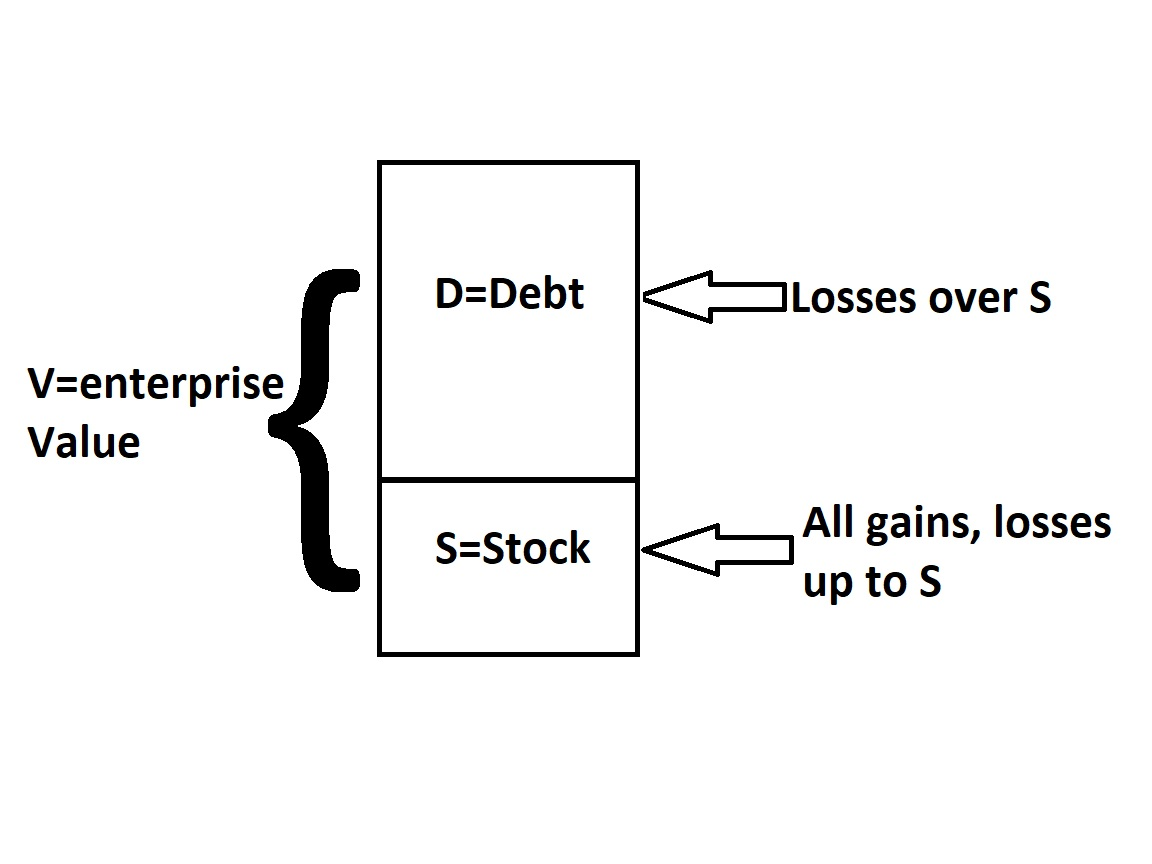

[Merton's 1974 paper](https://doi.org/10.1111/j.1540-6261.1974.tb03058.x) noted that the payoff pattern to debtholders &mdash; linearly increasing in $V$ for $0<V<D$, and capped at $D$ when $V>D$ &mdash; is the same as the payoff pattern to someone who owns the corporation (i.e. owns $V$) but who has also sold a call option on the corporation struck at price $D$. The stockholders own the call option on the enterprise value, struck at $D$.

When the call option is far in the money &mdash; i.e. the value of the enterprise is much higher than $D$ &mdash; then changes in the value of the enterprise cause comparatively small percentage changes in the value of the stock (i.e. the option on the enterprise that the stockholders own).

However as the value of the enterprise gets smaller and closer to the value of the debt $D$, the percentage swings in the stock get larger and larger as the company approaches bankruptcy and the shareholders approach zero value.

This argues in favor of asymmetric impact of returns. If there is a downward shock, that gets the value of the enterprise closer to the debt barrier and should increase volatility. If there is an upward shock, that gets the value of the enterprise further away from the debt barrier and should decrease volatility. This argument &mdash; essentially that leverage increases with negative shocks &mdash; has some practical problems as it has been shown to not fully explain asymmetries, but the empirical fact of asymmetry is unassailable.

One way of dealing with asymmetry is to have a threshold on the shocks $y_t$. This gives rise to a variety of models with names like TARCH, TGARCH, and QTARCH. The [GJR (Glosten, Jagannathan, Runkle) 1993 TARCH model](https://www.jstor.org/stable/2329067) added a term that gave an extra boost to variance when there were negative returns:
$$\sigma_t^2=a_1 y_{t-1}^2+\delta(y_{t-1}<0) a_1^{-} y_{t-1}^2\label{eq:tarch_model}\tag{9.60}$$
The $\delta$ function equals one when its Boolean argument is true, and equals zero otherwise. This is like \eqref{eq:arch_sigma} with $p=1$, but the extra term adds the desired asymmetry. An obvious extension can be made for $p>1$.

Another straightforward implementation is a TGARCH (also called GJR-GARCH) model, where another term for down-shocks is added to the GARCH(1,1) model in \eqref{eq:garch11_sigma}:
$$\sigma_t^2=c+b_1 \sigma_{t-1}^2+a_1 y_{t-1}^2+\delta(y_{t-1}<0) a_1^{-} y_{t-1}^2\label{eq:tgarch_model}\tag{9.61}$$
GJR-GARCH is the main market volatiity model used by the [Volatility Laboratory at New York University](https://vlab.stern.nyu.edu/docs/volatility). The [V-Lab notes](https://vlab.stern.nyu.edu/docs/volatility/GJR-GARCH) that if all parameters are positive and $b_1+a_1+\frac{a_1^{-}}{2}<1$, then $\sigma_t^2$ is mean-reverting to $\frac{c}{1-b_1-a_1-\frac{a_1^{-}}{2}}$.

The QTARCH model generalizes the delta function from positive/negative to pick out segments of the shock distribution – for example we could have different responses if the shock was between -1% and -5% than if it was between -5% and -12%. Of course the more parameters that are added to a model, the more chance there is of overfitting past data and degrading out-of-sample performance.

An approach that may not suffer as much from overfitting is to change the abrupt transition caused by the delta functions in \eqref{eq:tarch_model} and \eqref{eq:tgarch_model} to a smoother transition. Let $s(x)=1/(1+\text{exp}(kx))$. Note that as $k\to\infty$, $s(x)$ becomes the delta function $\delta(x<0)$. As we lower $k$, $s(x)$ still looks like the delta function but transitions more smoothly. We can use $(x-m)$ instead of $x$ to shift the transition point. Figure 9.11 illustrates this pseudo-delta function for some different values of $k$:

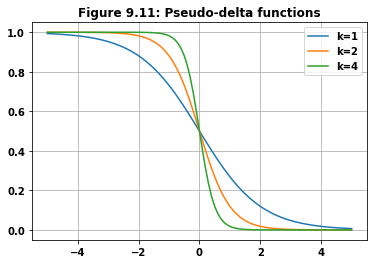

In [13]:
#Draw graph of pseudo-delta functions
xs=np.arange(-5,5.1,.1)

for k in [1,2,4]:
    ys=[1/(1+np.exp(k*x)) for x in xs]
    plt.plot(xs,ys,label='k='+str(k))

plt.legend()
plt.title('Figure 9.11: Pseudo-delta functions')
plt.grid()
plt.show()

Another GARCH variant is EGARCH, or Exponential GARCH. The idea is that there are various contortions of the GARCH parameters that are required to make sure that the variance comes out positive. Those contortions can be avoided by taking the log of the variance, which can range over the positive and negative real numbers while still preserving positive variance.

The EGARCH model was specified in [Nelson 1991](www.jstor.org/stable/2938260). Nelson didn't mimic the original GARCH specification directly. He had a term that took into account asymmetric responses to positive and negative shocks. Translating into terms we have used, the EGARCH(1,1) model is:
$$ln(\sigma_t^2)=c+b_1 ln(\sigma_{t-1}^2)+a_1 y_{t-1}^2+\delta(y_{t-1}<0)a_1^{-}y_{t-1}^2\label{eq:egarch_model}\tag{9.62}$$
While this seems plausible, empirical tests done by [Engle and Ng 1993](https://doi.org/10.1111/j.1540-6261.1993.tb05127.x) show that EGARCH overweights the effects of big shocks and ends up fitting actual data more poorly than the GARCH model.

## Chapter 9 Footnotes
<a name="nine_footnotes"></a>
<br>
$^1$ Graham, Benjamin. Jason Zweig, ed., 2003 Edition. *The Intelligent Investor.* HarperCollins. ISBN 0-06-055566-1.
<br><br>
$^2$ https://www.gsarchive.net/mikado/webopera/mk208d.html
<br><br>
$^3$ Most options traded in the United States are American-style. Clever variants have sprouted in the witty hothouses of options trading desks: a **`Bermudian option`** is one that can be exercised at a predetermined number of points between now and expiration, say once a month. Bermuda is geographically somewhere between America and Europe and the exercise style is somewhere between American-style and European-style, but this style of option otherwise has nothing to do with Bermuda. Similarly, an **`Asian option`** is one where the exercise price is the average of prices seen during the life of the option rather than the ending price. Asia seems to have been chosen simply because (like the terms of the option) it's different from America and Europe, not because this style of option is particularly favored in Asia.
<br><br>
$^4$ “Option Greeks” are terms that denote an instrument's sensitivity to various factors, such as interest Rates (rho), the passage of Time (theta). These two examples are Greek letters and have the first-letter mnemonic T-theta-time and R-rho-rates. Other option Greeks are not actually Greek letters like vega (volatility sensitivity); there is no Greek letter starting with "v," but Vega (actually a star in the Lyra constellation) sounds plausible. Purists who insist on actual Greek letters use "kappa" for volatility sensitivity, losing the first-letter mnemonic. Some second-order option Greeks are just made-up words like "vomma," the second derivative with respect to volatility. We will look at option Greeks in more detail in Chapter 12.
<br><br>
$^5$ Ilya Glickman has a nice one-page proof of this here: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1756450
<br><br>
$^6$ Morini, Massimo. Understanding and Managing Model Risk. Wiley Finance, 2011.  ISBN-13: 978-0470977613. pp. 230-231.